In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_15/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_15.csv').drop(columns=['주택가격지수']).dropna()
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]
print(training_data_df.shape)
training_data_df.head()

(3980330, 384)
Wall time: 1min 41s


,금액(만원),층,가격면적,target_log_transformed,targetarea_log_transformed,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,철근콘크리트구조_fraction,철골철근콘크리트구조_fraction,벽돌구조_fraction,프리케스트콘크리트구조_fraction,경량철골구조_fraction,철골콘크리트구조_fraction,일반철골구조_fraction,블록구조_fraction,일반목구조_fraction,기타조적구조_fraction,기타강구조_fraction,강파이프구조_fraction,기타구조_fraction,석구조_fraction,기타콘크리트구조_fraction,라멘조_fraction,조립식판넬조_fraction,주_용도_공동주택_fraction,주_용도_종교시설_fraction,주_용도_제2종근린생활시설_fraction,주_용도_단독주택_fraction,주_용도_제1종근린생활시설_fraction,주_용도_교육연구시설_fraction,주_용도_판매시설_fraction,주_용도_노유자시설_fraction,주_용도_자동차관련시설_fraction,주_용도_업무시설_fraction,주_용도_운동시설_fraction,주_용도_창고시설_fraction,주_용도_문화및집회시설_fraction,주_용도_위락시설_fraction,주_용도_숙박시설_fraction,주_용도_근린생활시설_fraction,주_용도_위험물저장및처리시설_fraction,주_용도_동.식물관련시설_fraction,주_용도_의료시설_fraction,주_용도_공장_fraction,주_용도_관광휴게시설_fraction,주_용도_수련시설_fraction,주_용도_판매및영업시설_fraction,주_용도_교육연구및복지시설_fraction,지붕_평지붕_fraction,지붕_철콘지붕_fraction,지붕_경사지붕_fraction,지붕_기타지붕_fraction,지붕_기와지붕_fraction,지붕_판넬지붕_fraction,지붕_박공지붕_fraction,지붕_모임지붕_fraction,지붕_스페니쉬기와_fraction,지붕_슬레이트지붕_fraction,지붕_초가지붕_fraction,지붕_멘사드지붕_fraction,지붕_철골지붕_fraction,지붕_함석지붕_fraction,지붕_목구조지붕_fraction,지붕_원형지붕_fraction,지붕_금속지붕_fraction,지붕_전통지붕_fraction,지붕_비닐지붕_fraction,층min,층max,층mean,층median,층norm,지하세대있음,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M~12M),소로2류(폭_8M~10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M~25M),중로2류(폭_15M~20M),중로3류(폭_12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,57000.0,2,733.118971,10.950807,6.597308,77.75,77.75,77.75,0,7.666667,-0.866025,-0.500000,0.55791,-0.904896,0.155632,0.409418,0.529414,-0.786361,0.848364,0.617768,-0.50485,0,921.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.

In [3]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

,colname
0,trade_type
1,표준지여부
2,건물나이
3,지목명
4,용도지역명1


In [4]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [5]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [6]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [7]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(796066, 384)
(636853, 384)
(2547411, 384)


In [8]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed']#, 'land_area_log']

In [9]:
x_test = test_data.drop(columns=target_cols)
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

(796066, 380)
(796066,)


In [10]:
x_valid = valid_data.drop(columns=target_cols)
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

(636853, 380)
(636853,)


In [11]:
x_train = train_data.drop(columns=target_cols)
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

(2547411, 380)
(2547411,)


<AxesSubplot:>

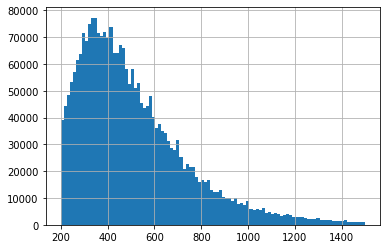

In [12]:
y_train.hist(bins=100)

# Training

In [13]:
from sklearn.metrics import r2_score

# ML Models

# Light GBM

In [14]:
import lightgbm as lgb

In [15]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'huber'
}

In [16]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [17]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=200, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.649520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6787
[LightGBM] [Info] Number of data points in the train set: 2547411, number of used features: 362


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 510.668273
Training until validation scores don't improve for 200 rounds
[50]	valid_0's huber: 89.7854
[100]	valid_0's huber: 74.2489
[150]	valid_0's huber: 67.8431
[200]	valid_0's huber: 64.5322
[250]	valid_0's huber: 62.5336
[300]	valid_0's huber: 61.1036
[350]	valid_0's huber: 59.9543
[400]	valid_0's huber: 59.0324
[450]	valid_0's huber: 58.2799
[500]	valid_0's huber: 57.6669
[550]	valid_0's huber: 57.1108
[600]	valid_0's huber: 56.6194
[650]	valid_0's huber: 56.1958
[700]	valid_0's huber: 55.7931
[750]	valid_0's huber: 55.3854
[800]	valid_0's huber: 55.019
[850]	valid_0's huber: 54.6828
[900]	valid_0's huber: 54.3792
[950]	valid_0's huber: 54.0967
[1000]	valid_0's huber: 53.7904
[1050]	valid_0's huber: 53.5498
[1100]	valid_0's huber: 53.3018
[1150]	valid_0's huber: 53.0708
[1200]	valid_0's huber: 52.8567
[1250]	valid_0's huber: 52.6582
[1300]	valid_0's huber: 52.4495
[1350]	valid_0's huber: 52.2581
[1400]	valid_0's huber: 52.077
[1450]	va

[12700]	valid_0's huber: 43.5001
[12750]	valid_0's huber: 43.4888
[12800]	valid_0's huber: 43.4781
[12850]	valid_0's huber: 43.4661
[12900]	valid_0's huber: 43.4556
[12950]	valid_0's huber: 43.4447
[13000]	valid_0's huber: 43.434
[13050]	valid_0's huber: 43.4233
[13100]	valid_0's huber: 43.4111
[13150]	valid_0's huber: 43.3996
[13200]	valid_0's huber: 43.3891
[13250]	valid_0's huber: 43.3785
[13300]	valid_0's huber: 43.3678
[13350]	valid_0's huber: 43.357
[13400]	valid_0's huber: 43.3456
[13450]	valid_0's huber: 43.3333
[13500]	valid_0's huber: 43.3239
[13550]	valid_0's huber: 43.3142
[13600]	valid_0's huber: 43.3052
[13650]	valid_0's huber: 43.296
[13700]	valid_0's huber: 43.2853
[13750]	valid_0's huber: 43.276
[13800]	valid_0's huber: 43.2668
[13850]	valid_0's huber: 43.256
[13900]	valid_0's huber: 43.2468
[13950]	valid_0's huber: 43.2374
[14000]	valid_0's huber: 43.2272
[14050]	valid_0's huber: 43.2159
[14100]	valid_0's huber: 43.2052
[14150]	valid_0's huber: 43.1938
[14200]	valid_0

[25200]	valid_0's huber: 41.7579
[25250]	valid_0's huber: 41.7531
[25300]	valid_0's huber: 41.7486
[25350]	valid_0's huber: 41.7447
[25400]	valid_0's huber: 41.7403
[25450]	valid_0's huber: 41.736
[25500]	valid_0's huber: 41.7329
[25550]	valid_0's huber: 41.7291
[25600]	valid_0's huber: 41.7246
[25650]	valid_0's huber: 41.7208
[25700]	valid_0's huber: 41.7166
[25750]	valid_0's huber: 41.7128
[25800]	valid_0's huber: 41.7084
[25850]	valid_0's huber: 41.7048
[25900]	valid_0's huber: 41.7015
[25950]	valid_0's huber: 41.6966
[26000]	valid_0's huber: 41.6931
[26050]	valid_0's huber: 41.6885
[26100]	valid_0's huber: 41.6844
[26150]	valid_0's huber: 41.6802
[26200]	valid_0's huber: 41.6754
[26250]	valid_0's huber: 41.6703
[26300]	valid_0's huber: 41.6666
[26350]	valid_0's huber: 41.6636
[26400]	valid_0's huber: 41.6601
[26450]	valid_0's huber: 41.6554
[26500]	valid_0's huber: 41.6506
[26550]	valid_0's huber: 41.6472
[26600]	valid_0's huber: 41.6434
[26650]	valid_0's huber: 41.6398
[26700]	val

[37700]	valid_0's huber: 40.9514
[37750]	valid_0's huber: 40.9491
[37800]	valid_0's huber: 40.9464
[37850]	valid_0's huber: 40.9441
[37900]	valid_0's huber: 40.942
[37950]	valid_0's huber: 40.9391
[38000]	valid_0's huber: 40.9366
[38050]	valid_0's huber: 40.9336
[38100]	valid_0's huber: 40.9315
[38150]	valid_0's huber: 40.9293
[38200]	valid_0's huber: 40.9274
[38250]	valid_0's huber: 40.9252
[38300]	valid_0's huber: 40.9232
[38350]	valid_0's huber: 40.9207
[38400]	valid_0's huber: 40.919
[38450]	valid_0's huber: 40.9164
[38500]	valid_0's huber: 40.9138
[38550]	valid_0's huber: 40.9108
[38600]	valid_0's huber: 40.9084
[38650]	valid_0's huber: 40.9066
[38700]	valid_0's huber: 40.905
[38750]	valid_0's huber: 40.9026
[38800]	valid_0's huber: 40.901
[38850]	valid_0's huber: 40.8987
[38900]	valid_0's huber: 40.8967
[38950]	valid_0's huber: 40.8942
[39000]	valid_0's huber: 40.8919
[39050]	valid_0's huber: 40.8892
[39100]	valid_0's huber: 40.8874
[39150]	valid_0's huber: 40.886
[39200]	valid_0

[50200]	valid_0's huber: 40.4555
[50250]	valid_0's huber: 40.4542
[50300]	valid_0's huber: 40.4523
[50350]	valid_0's huber: 40.4509
[50400]	valid_0's huber: 40.4486
[50450]	valid_0's huber: 40.4465
[50500]	valid_0's huber: 40.4453
[50550]	valid_0's huber: 40.444
[50600]	valid_0's huber: 40.4425
[50650]	valid_0's huber: 40.4408
[50700]	valid_0's huber: 40.4396
[50750]	valid_0's huber: 40.4383
[50800]	valid_0's huber: 40.4365
[50850]	valid_0's huber: 40.4351
[50900]	valid_0's huber: 40.4334
[50950]	valid_0's huber: 40.4317
[51000]	valid_0's huber: 40.4302
[51050]	valid_0's huber: 40.4286
[51100]	valid_0's huber: 40.427
[51150]	valid_0's huber: 40.4257
[51200]	valid_0's huber: 40.425
[51250]	valid_0's huber: 40.4234
[51300]	valid_0's huber: 40.4212
[51350]	valid_0's huber: 40.4192
[51400]	valid_0's huber: 40.4179
[51450]	valid_0's huber: 40.4165
[51500]	valid_0's huber: 40.4148
[51550]	valid_0's huber: 40.4128
[51600]	valid_0's huber: 40.4112
[51650]	valid_0's huber: 40.4092
[51700]	valid

[62700]	valid_0's huber: 40.1199
[62750]	valid_0's huber: 40.1189
[62800]	valid_0's huber: 40.1178
[62850]	valid_0's huber: 40.1167
[62900]	valid_0's huber: 40.1159
[62950]	valid_0's huber: 40.1151
[63000]	valid_0's huber: 40.1143
[63050]	valid_0's huber: 40.113
[63100]	valid_0's huber: 40.1123
[63150]	valid_0's huber: 40.1116
[63200]	valid_0's huber: 40.1106
[63250]	valid_0's huber: 40.1094
[63300]	valid_0's huber: 40.1084
[63350]	valid_0's huber: 40.1072
[63400]	valid_0's huber: 40.1059
[63450]	valid_0's huber: 40.1045
[63500]	valid_0's huber: 40.1031
[63550]	valid_0's huber: 40.1018
[63600]	valid_0's huber: 40.1009
[63650]	valid_0's huber: 40.0998
[63700]	valid_0's huber: 40.0985
[63750]	valid_0's huber: 40.0974
[63800]	valid_0's huber: 40.0961
[63850]	valid_0's huber: 40.0949
[63900]	valid_0's huber: 40.0939
[63950]	valid_0's huber: 40.0926
[64000]	valid_0's huber: 40.0914
[64050]	valid_0's huber: 40.0901
[64100]	valid_0's huber: 40.0888
[64150]	valid_0's huber: 40.0875
[64200]	val

[75200]	valid_0's huber: 39.8836
[75250]	valid_0's huber: 39.8828
[75300]	valid_0's huber: 39.8813
[75350]	valid_0's huber: 39.8807
[75400]	valid_0's huber: 39.8798
[75450]	valid_0's huber: 39.8793
[75500]	valid_0's huber: 39.8784
[75550]	valid_0's huber: 39.8783
[75600]	valid_0's huber: 39.8775
[75650]	valid_0's huber: 39.8768
[75700]	valid_0's huber: 39.8761
[75750]	valid_0's huber: 39.8753
[75800]	valid_0's huber: 39.8748
[75850]	valid_0's huber: 39.8743
[75900]	valid_0's huber: 39.8735
[75950]	valid_0's huber: 39.872
[76000]	valid_0's huber: 39.8709
[76050]	valid_0's huber: 39.87
[76100]	valid_0's huber: 39.8694
[76150]	valid_0's huber: 39.8688
[76200]	valid_0's huber: 39.8682
[76250]	valid_0's huber: 39.8673
[76300]	valid_0's huber: 39.8663
[76350]	valid_0's huber: 39.8651
[76400]	valid_0's huber: 39.864
[76450]	valid_0's huber: 39.8632
[76500]	valid_0's huber: 39.8624
[76550]	valid_0's huber: 39.8615
[76600]	valid_0's huber: 39.8608
[76650]	valid_0's huber: 39.8598
[76700]	valid_

[87700]	valid_0's huber: 39.7077
[87750]	valid_0's huber: 39.7071
[87800]	valid_0's huber: 39.7064
[87850]	valid_0's huber: 39.7056
[87900]	valid_0's huber: 39.7053
[87950]	valid_0's huber: 39.7049
[88000]	valid_0's huber: 39.7045
[88050]	valid_0's huber: 39.7041
[88100]	valid_0's huber: 39.7037
[88150]	valid_0's huber: 39.7035
[88200]	valid_0's huber: 39.7032
[88250]	valid_0's huber: 39.7027
[88300]	valid_0's huber: 39.7022
[88350]	valid_0's huber: 39.7016
[88400]	valid_0's huber: 39.7011
[88450]	valid_0's huber: 39.7003
[88500]	valid_0's huber: 39.6999
[88550]	valid_0's huber: 39.6996
[88600]	valid_0's huber: 39.6991
[88650]	valid_0's huber: 39.6986
[88700]	valid_0's huber: 39.6983
[88750]	valid_0's huber: 39.6977
[88800]	valid_0's huber: 39.6971
[88850]	valid_0's huber: 39.6965
[88900]	valid_0's huber: 39.6961
[88950]	valid_0's huber: 39.6957
[89000]	valid_0's huber: 39.695
[89050]	valid_0's huber: 39.6945
[89100]	valid_0's huber: 39.6936
[89150]	valid_0's huber: 39.6931
[89200]	val

[100150]	valid_0's huber: 39.5756
[100200]	valid_0's huber: 39.5751
[100250]	valid_0's huber: 39.5744
[100300]	valid_0's huber: 39.5738
[100350]	valid_0's huber: 39.5734
[100400]	valid_0's huber: 39.5725
[100450]	valid_0's huber: 39.572
[100500]	valid_0's huber: 39.5713
[100550]	valid_0's huber: 39.571
[100600]	valid_0's huber: 39.5704
[100650]	valid_0's huber: 39.5697
[100700]	valid_0's huber: 39.5693
[100750]	valid_0's huber: 39.569
[100800]	valid_0's huber: 39.5686
[100850]	valid_0's huber: 39.5681
[100900]	valid_0's huber: 39.5676
[100950]	valid_0's huber: 39.5669
[101000]	valid_0's huber: 39.5664
[101050]	valid_0's huber: 39.5661
[101100]	valid_0's huber: 39.5656
[101150]	valid_0's huber: 39.565
[101200]	valid_0's huber: 39.5644
[101250]	valid_0's huber: 39.564
[101300]	valid_0's huber: 39.5633
[101350]	valid_0's huber: 39.5627
[101400]	valid_0's huber: 39.5621
[101450]	valid_0's huber: 39.5615
[101500]	valid_0's huber: 39.5611
[101550]	valid_0's huber: 39.5607
[101600]	valid_0's 

[112250]	valid_0's huber: 39.4724
[112300]	valid_0's huber: 39.4721
[112350]	valid_0's huber: 39.4716
[112400]	valid_0's huber: 39.4714
[112450]	valid_0's huber: 39.471
[112500]	valid_0's huber: 39.4707
[112550]	valid_0's huber: 39.4704
[112600]	valid_0's huber: 39.4701
[112650]	valid_0's huber: 39.4695
[112700]	valid_0's huber: 39.4691
[112750]	valid_0's huber: 39.4687
[112800]	valid_0's huber: 39.4683
[112850]	valid_0's huber: 39.4681
[112900]	valid_0's huber: 39.468
[112950]	valid_0's huber: 39.4677
[113000]	valid_0's huber: 39.4677
[113050]	valid_0's huber: 39.4674
[113100]	valid_0's huber: 39.4672
[113150]	valid_0's huber: 39.4669
[113200]	valid_0's huber: 39.4666
[113250]	valid_0's huber: 39.4664
[113300]	valid_0's huber: 39.4663
[113350]	valid_0's huber: 39.4658
[113400]	valid_0's huber: 39.4654
[113450]	valid_0's huber: 39.4652
[113500]	valid_0's huber: 39.4649
[113550]	valid_0's huber: 39.4644
[113600]	valid_0's huber: 39.4641
[113650]	valid_0's huber: 39.4639
[113700]	valid_0

[124350]	valid_0's huber: 39.4004
[124400]	valid_0's huber: 39.4003
[124450]	valid_0's huber: 39.4
[124500]	valid_0's huber: 39.3996
[124550]	valid_0's huber: 39.3994
[124600]	valid_0's huber: 39.3992
[124650]	valid_0's huber: 39.3991
[124700]	valid_0's huber: 39.3987
[124750]	valid_0's huber: 39.3986
[124800]	valid_0's huber: 39.3983
[124850]	valid_0's huber: 39.3981
[124900]	valid_0's huber: 39.3978
[124950]	valid_0's huber: 39.3975
[125000]	valid_0's huber: 39.3973
[125050]	valid_0's huber: 39.3971
[125100]	valid_0's huber: 39.3969
[125150]	valid_0's huber: 39.3962
[125200]	valid_0's huber: 39.396
[125250]	valid_0's huber: 39.3958
[125300]	valid_0's huber: 39.3955
[125350]	valid_0's huber: 39.3956
[125400]	valid_0's huber: 39.3953
[125450]	valid_0's huber: 39.3949
[125500]	valid_0's huber: 39.3946
[125550]	valid_0's huber: 39.3942
[125600]	valid_0's huber: 39.3939
[125650]	valid_0's huber: 39.3936
[125700]	valid_0's huber: 39.3934
[125750]	valid_0's huber: 39.3931
[125800]	valid_0's

[136450]	valid_0's huber: 39.3387
[136500]	valid_0's huber: 39.3384
[136550]	valid_0's huber: 39.3382
[136600]	valid_0's huber: 39.338
[136650]	valid_0's huber: 39.3378
[136700]	valid_0's huber: 39.3375
[136750]	valid_0's huber: 39.3372
[136800]	valid_0's huber: 39.3371
[136850]	valid_0's huber: 39.3369
[136900]	valid_0's huber: 39.3369
[136950]	valid_0's huber: 39.3369
[137000]	valid_0's huber: 39.3369
[137050]	valid_0's huber: 39.3367
[137100]	valid_0's huber: 39.3365
[137150]	valid_0's huber: 39.3362
[137200]	valid_0's huber: 39.3359
[137250]	valid_0's huber: 39.3359
[137300]	valid_0's huber: 39.3357
[137350]	valid_0's huber: 39.3356
[137400]	valid_0's huber: 39.3355
[137450]	valid_0's huber: 39.3353
[137500]	valid_0's huber: 39.335
[137550]	valid_0's huber: 39.3347
[137600]	valid_0's huber: 39.3345
[137650]	valid_0's huber: 39.3342
[137700]	valid_0's huber: 39.3342
[137750]	valid_0's huber: 39.3342
[137800]	valid_0's huber: 39.334
[137850]	valid_0's huber: 39.3338
[137900]	valid_0'

In [18]:
import shap

In [19]:
explainer = shap.TreeExplainer(bst)

In [20]:
sample_df = x_valid.sample(n=1000)

In [21]:
shap_values = explainer.shap_values(sample_df)

In [22]:
shap_values_df = pd.DataFrame(shap_values)

In [23]:
shap_summary_df = pd.DataFrame()

In [24]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [25]:
shap_summary_df.columns = x_valid.columns

In [26]:
shap_summary_df = shap_summary_df.transpose().sort_values(0, ascending=False)

In [27]:
shap_summary_df.head(50)

,0
trade_type,86.241751
year_linear,76.164656
공시지가(만원),67.803820
건물나이,37.877621
ynorm,31.793282
토지면적,24.463358
전용면적_mean,24.035608
xy,21.981069
층max,13.544154
x_2nd,10.300500


In [ ]:
under_zero_df = over_zero_df = shap_summary_df[shap_summary_df[0] <= 0]
under_zero_df.shape

In [ ]:
under_zero_df

In [ ]:
over_zero_df = shap_summary_df[shap_summary_df[0] > 0]
over_zero_df.shape

In [ ]:
over_zero_df = over_zero_df.transpose()
over_zero_df.head()

In [ ]:
over_zero_df.to_csv(basedir + 'over_zero_shap_score_features.csv', index=False)

In [ ]:
selected_features = over_zero_df.columns.tolist()

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
import lightgbm as lgb

In [ ]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse',
    'tree_learner':'feature'
}

In [ ]:
cat_cols = [col for col in cat_cols if col in selected_features]
len(cat_cols)

In [ ]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [ ]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=5000, verbose_eval=50)

In [ ]:
lgb.plot_importance(bst)

In [ ]:
preds = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
bst.save_model('lgb_model_for_training_data_ver_8.txt')

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_training_data_ver_8.csv', index=False)

In [ ]:
pd.DataFrame({'preds':preds}).to_csv('lgb_preds_training_data_ver_8.csv', index=False)

In [ ]:
y_test_pricearea = test_data['가격/면적']

In [ ]:
r2_score(y_test, preds)

In [ ]:
r2_score(y_test_pricearea, np.e**preds)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, preds)

In [ ]:
mean_squared_error(y_test_pricearea, np.e**preds)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'preds':preds})
print(compare_df.shape)
compare_df.head(50)

In [ ]:
compare_df.tail()

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.01)#, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)

In [ ]:
%%time
shap_values = model.get_feature_importance(data=val_pool, type='ShapValues')

In [ ]:
shap_values.shape

In [ ]:
val_pool.shape

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
colnames_map_df = pd.DataFrame({'colnames':x_valid.columns,'map':[i for i in range(len(x_valid.columns))]})
colnames_map_df.head()

In [ ]:
x_valid.columns = colnames_map_df['map'].tolist()
x_valid.head()

In [ ]:
summary = shap.summary_plot(shap_values[:,:-1], x_valid, max_display=x_valid.shape[1])

In [ ]:
shap_values_df = pd.DataFrame(shap_values[:,:-1])
shap_values_df.head()

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
np.mean(np.abs(shap_values_df[0].values))

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values([0], ascending=False)

In [ ]:
shap_summary_df.head()

In [ ]:
selected_features_map = shap_summary_df.index[:330].values

In [ ]:
selected_features_list = []
for v in selected_features_map:
    selected_features_list.append(colnames_map_df.iloc[v,0])

In [ ]:
selected_features_list

In [ ]:
selected_features_df = pd.DataFrame({'colnames':selected_features_list})
selected_features_df.head()

In [ ]:
selected_features_df.to_csv(basedir + 'selected_features.csv', index=False)

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features_list]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features_list]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features_list]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

In [ ]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

In [ ]:
cat_cols = [col for col in x_train.columns if col in cat_cols_list]
len(cat_cols)

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.001, depth=7, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)